In [32]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline

In [33]:
df = pd.read_csv("training_set.csv")
train = df.drop(['ARR_DELAY'], axis = 1)
y = df['ARR_DELAY']
df.head()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,FL_DATE,...,FL_NUM,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,FIRST_DEP_TIME,ARR_DELAY
0,0,2,1020,11,8,373,"2,701",11,19930,2017-01-03,...,879,AS,SEA,"Seattle, WA",WA,LIH,"Lihue, HI",HI,NaN,-11
1,1,6,1220,13,9,183,"1,171",5,19805,2017-01-28,...,2491,AA,SAN,"San Diego, CA",CA,DFW,"Dallas/Fort Worth, TX",TX,NaN,1
2,2,6,945,48,6,355,"2,552",11,19930,2017-01-21,...,172,AS,ANC,"Anchorage, AK",AK,PHX,"Phoenix, AZ",AZ,NaN,18
3,3,1,1437,17,8,136,967,4,19977,2017-01-23,...,2030,UA,SFO,"San Francisco, CA",CA,DEN,"Denver, CO",CO,NaN,0
4,4,1,830,37,7,114,534,3,19393,2017-01-02,...,3812,WN,ATL,"Atlanta, GA",GA,IAD,"Washington, DC",VA,NaN,197


# Data Cleaning

In [34]:
def cleaning(data):
    for i in range(len(data)):
        #print i
        data.loc[i, 'DISTANCE'] = data.loc[i, 'DISTANCE'].replace(',','')
        data.loc[i, 'DISTANCE'] = int(data.loc[i, 'DISTANCE'])

        date = data.loc[i, 'FL_DATE']
        data.loc[i, 'FL_DATE'] = datetime.datetime.strptime(date, '%Y-%m-%d')

        data.loc[i, 'DAY_OF_MONTH'] = data.loc[i, 'FL_DATE'].day
        data.loc[i, 'MONTH'] = data.loc[i, 'FL_DATE'].month

    return data

In [35]:
train = cleaning(train)
train.head()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,FL_DATE,...,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,FIRST_DEP_TIME,DAY_OF_MONTH,MONTH
0,0,2,1020,11,8,373,2701,11,19930,2017-01-03 00:00:00,...,AS,SEA,"Seattle, WA",WA,LIH,"Lihue, HI",HI,NaN,3.0,1.0
1,1,6,1220,13,9,183,1171,5,19805,2017-01-28 00:00:00,...,AA,SAN,"San Diego, CA",CA,DFW,"Dallas/Fort Worth, TX",TX,NaN,28.0,1.0
2,2,6,945,48,6,355,2552,11,19930,2017-01-21 00:00:00,...,AS,ANC,"Anchorage, AK",AK,PHX,"Phoenix, AZ",AZ,NaN,21.0,1.0
3,3,1,1437,17,8,136,967,4,19977,2017-01-23 00:00:00,...,UA,SFO,"San Francisco, CA",CA,DEN,"Denver, CO",CO,NaN,23.0,1.0
4,4,1,830,37,7,114,534,3,19393,2017-01-02 00:00:00,...,WN,ATL,"Atlanta, GA",GA,IAD,"Washington, DC",VA,NaN,2.0,1.0


# Data Pre-processing

In [36]:
def pre_processing(data):
    from sklearn.preprocessing import LabelEncoder  
    
    # Creating bins for continuous values in CRS_DEP_TIME feature
    CRS_DEP_TIME__bins = [0, 600, 1200, 1800, 2400]
    data['CRS_DEP_TIME'] = pd.cut(data['CRS_DEP_TIME'], CRS_DEP_TIME__bins)

    TAXI_OUT__bins = [0, 20, 40, 60, 80, 150]
    data['TAXI_OUT'] = pd.cut(data['TAXI_OUT'], TAXI_OUT__bins)
    
    TAXI_IN__bins = [0, 10, 20, 30, 40, 85] 
    data['TAXI_IN'] = pd.cut(data['TAXI_IN'], TAXI_IN__bins)
    
    ACTUAL_ELAPSED_TIME__bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 650]
    data['ACTUAL_ELAPSED_TIME'] = pd.cut(data['ACTUAL_ELAPSED_TIME'], ACTUAL_ELAPSED_TIME__bins)
    
    DISTANCE__bins = np.arange(0, 5100, 100)
    data['DISTANCE'] = pd.cut(data['DISTANCE'], DISTANCE__bins)
    
    # Changing string to int values
    le = LabelEncoder()
    data['ORIG_STATE'] = le.fit_transform(data['ORIGIN_STATE_ABR'])

    # Using Python's Dictionary as Hash-Map to to encode states as integers
    # Using the same encoding for Destination State as well (for consistency)
    states = {}

    for i in range(len(data)):
        key = data.loc[i, 'ORIGIN_STATE_ABR']
        value = data.loc[i, 'ORIG_STATE']
        states[key] = value

    for i in range(len(data)):
        val = data.loc[i, 'DEST_STATE_ABR']
        data.loc[i, 'DEST_STATE'] = states[val]
        data.loc[i, 'DEP_TIME'] = data.loc[i, 'CRS_DEP_TIME'].mid
        data.loc[i, 'OUT_TAXI'] = data.loc[i, 'TAXI_OUT'].mid
        data.loc[i, 'IN_TAXI'] = data.loc[i, 'TAXI_IN'].mid
        data.loc[i, 'ELAPSED_TIME'] = data.loc[i, 'ACTUAL_ELAPSED_TIME'].mid
        data.loc[i, 'NEW_DIST_GROUP'] = data.loc[i, 'DISTANCE'].mid

    return data

train = pre_processing(train)
train.head()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,FL_DATE,...,FIRST_DEP_TIME,DAY_OF_MONTH,MONTH,ORIG_STATE,DEST_STATE,DEP_TIME,OUT_TAXI,IN_TAXI,ELAPSED_TIME,NEW_DIST_GROUP
0,0,2,"(600, 1200]","(0, 20]","(0, 10]","(360, 390]","(2700, 2800]",11,19930,2017-01-03 00:00:00,...,NaN,3.0,1.0,47,9.0,900.0,10.0,5.0,375.0,2750.0
1,1,6,"(1200, 1800]","(0, 20]","(0, 10]","(180, 210]","(1100, 1200]",5,19805,2017-01-28 00:00:00,...,NaN,28.0,1.0,4,42.0,1500.0,10.0,5.0,195.0,1150.0
2,2,6,"(600, 1200]","(40, 60]","(0, 10]","(330, 360]","(2500, 2600]",11,19930,2017-01-21 00:00:00,...,NaN,21.0,1.0,0,3.0,900.0,50.0,5.0,345.0,2550.0
3,3,1,"(1200, 1800]","(0, 20]","(0, 10]","(120, 150]","(900, 1000]",4,19977,2017-01-23 00:00:00,...,NaN,23.0,1.0,4,5.0,1500.0,10.0,5.0,135.0,950.0
4,4,1,"(600, 1200]","(20, 40]","(0, 10]","(90, 120]","(500, 600]",3,19393,2017-01-02 00:00:00,...,NaN,2.0,1.0,8,44.0,900.0,30.0,5.0,105.0,550.0


## Removing redundant features

In [37]:
# Dropping the un-cleaned columns (ONLY FOR NOW !!!)
redundant_cols = ['UID', 'FL_NUM','FIRST_DEP_TIME', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_STATE_ABR', 
                  'UNIQUE_CARRIER']
new_train = train.drop(redundant_cols, axis=1)

# These features have been used to create new features which made more sense
treated_cols = ['FL_DATE', 'ORIGIN_STATE_ABR', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'TAXI_OUT',
               'TAXI_IN', 'ACTUAL_ELAPSED_TIME', 'DISTANCE']
new_train = new_train.drop(treated_cols, axis=1)

new_train.head()

,DAY_OF_WEEK,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,DAY_OF_MONTH,MONTH,ORIG_STATE,DEST_STATE,DEP_TIME,OUT_TAXI,IN_TAXI,ELAPSED_TIME,NEW_DIST_GROUP
0,2,11,19930,30559,32982,3.0,1.0,47,9.0,900.0,10.0,5.0,375.0,2750.0
1,6,5,19805,33570,30194,28.0,1.0,4,42.0,1500.0,10.0,5.0,195.0,1150.0
2,6,11,19930,30299,30466,21.0,1.0,0,3.0,900.0,50.0,5.0,345.0,2550.0
3,1,4,19977,32457,30325,23.0,1.0,4,5.0,1500.0,10.0,5.0,135.0,950.0
4,1,3,19393,30397,30852,2.0,1.0,8,44.0,900.0,30.0,5.0,105.0,550.0


In [38]:
new_train.to_csv("Clean_train.csv")
cols = new_train.columns.values

In [39]:
cols

array(['DAY_OF_WEEK', 'DISTANCE_GROUP', 'AIRLINE_ID',
       'ORIGIN_CITY_MARKET_ID', 'DEST_CITY_MARKET_ID', 'DAY_OF_MONTH',
       'MONTH', 'ORIG_STATE', 'DEST_STATE', 'DEP_TIME', 'OUT_TAXI',
       'IN_TAXI', 'ELAPSED_TIME', 'NEW_DIST_GROUP'], dtype=object)

In [40]:
from sklearn.preprocessing import RobustScaler

RobustScaler()
scaler_x = RobustScaler().fit(new_train)
scaler_y = RobustScaler().fit(y.reshape(-1, 1))

scaled_train = scaler_x.transform(new_train)
scaled_y = scaler_y.transform(y.reshape(-1, 1))

scaled_train = pd.DataFrame(scaled_train, columns=cols)
scaled_y = pd.DataFrame(y, columns = ["ARR_DELAY"])

/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [41]:
scaled_train.describe()

,DAY_OF_WEEK,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,DAY_OF_MONTH,MONTH,ORIG_STATE,DEST_STATE,DEP_TIME,OUT_TAXI,IN_TAXI,ELAPSED_TIME,NEW_DIST_GROUP
count,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000
mean,-0.015883,0.290301,0.194604,0.162429,0.147630,-0.005180,-0.078090,0.129936,0.130876,-0.246386,5.045816,2.264814,0.064492,0.283853
std,0.498191,0.815056,0.741757,0.703847,0.681799,0.555781,0.574723,0.579573,0.577315,0.839682,10.667772,6.432769,0.875741,0.885045
min,-0.750000,-0.666667,-0.801556,-0.758791,-0.732521,-0.937500,-1.000000,-0.653846,-0.653846,-2.000000,0.000000,0.000000,-1.000000,-0.857143
25%,-0.500000,-0.333333,-0.029183,-0.443407,-0.426907,-0.500000,-0.500000,-0.384615,-0.384615,-1.000000,0.000000,0.000000,-0.666667,-0.428571
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.666667,0.970817,0.556593,0.573093,0.500000,0.500000,0.615385,0.615385,0.000000,0.000000,0.000000,0.333333,0.571429
max,0.750000,2.666667,2.657588,2.492857,2.324153,0.937500,0.833333,1.230769,1.230769,1.000000,105.000000,57.500000,4.277778,6.142857


In [42]:
cols = []
for col in scaled_train:
    cols.append(col)
    # Printing the data type of last element of every feature
    print col, "\t\t", type(scaled_train[col][len(scaled_train)-1])

DAY_OF_WEEK 		<type 'numpy.float64'>
DISTANCE_GROUP 		<type 'numpy.float64'>
AIRLINE_ID 		<type 'numpy.float64'>
ORIGIN_CITY_MARKET_ID 		<type 'numpy.float64'>
DEST_CITY_MARKET_ID 		<type 'numpy.float64'>
DAY_OF_MONTH 		<type 'numpy.float64'>
MONTH 		<type 'numpy.float64'>
ORIG_STATE 		<type 'numpy.float64'>
DEST_STATE 		<type 'numpy.float64'>
DEP_TIME 		<type 'numpy.float64'>
OUT_TAXI 		<type 'numpy.float64'>
IN_TAXI 		<type 'numpy.float64'>
ELAPSED_TIME 		<type 'numpy.float64'>
NEW_DIST_GROUP 		<type 'numpy.float64'>


# Data Distribution

### Box-Plot

Outliers: 43


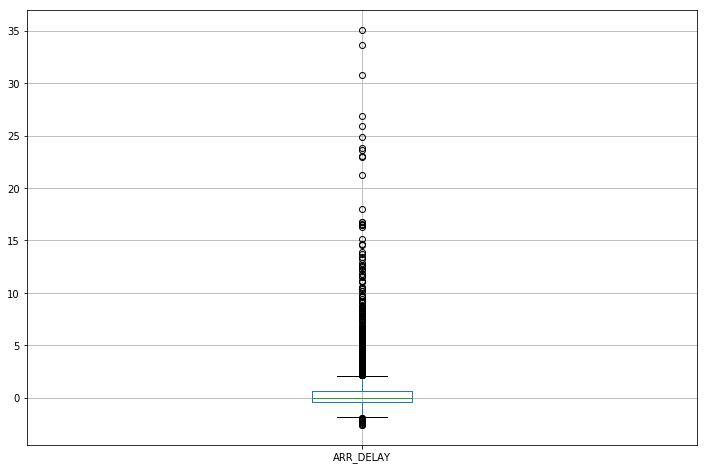

In [13]:
# Distribution of 'Arrival Delay'
plt.figure(figsize = (12, 8))
y.boxplot(column=['ARR_DELAY']) 

count = 0
for i in range(len(df)):
    if y.ARR_DELAY[i] > 10:
        count += 1
        
print "Outliers:", count

Outliers: 149


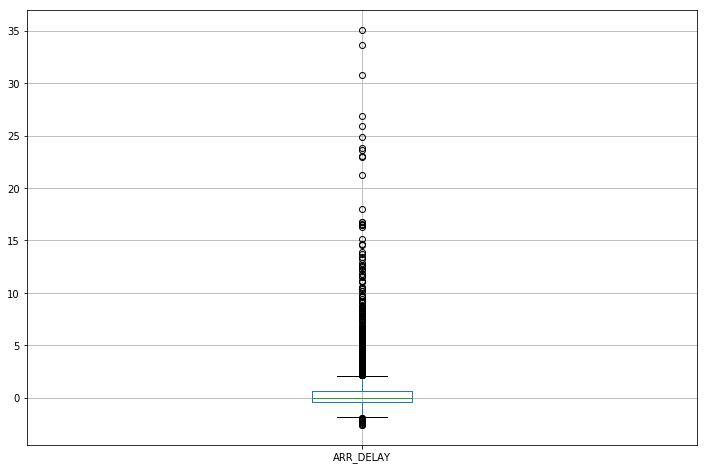

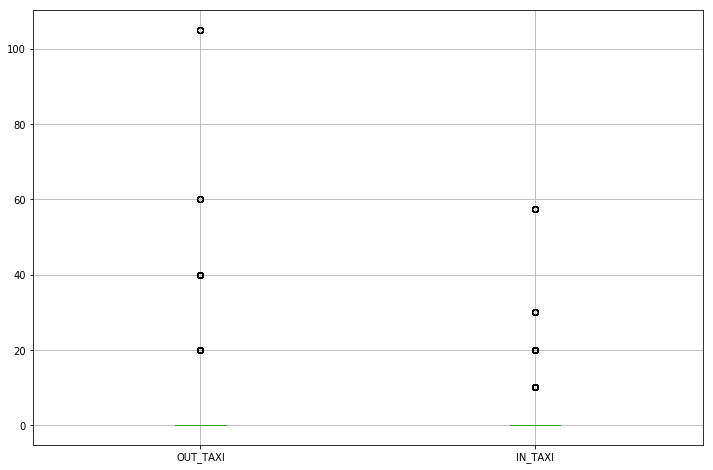

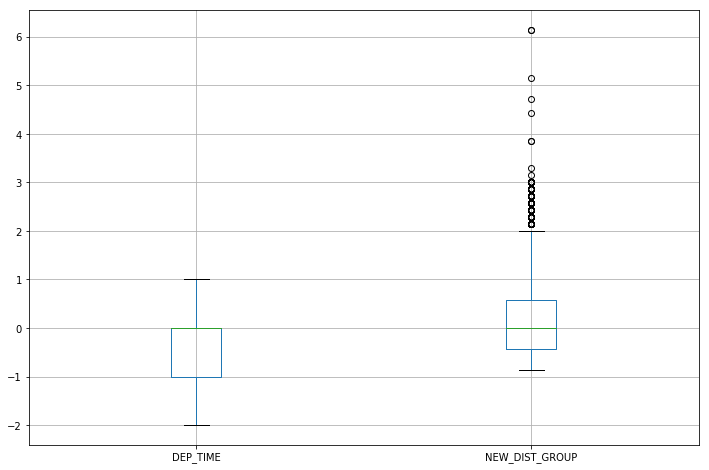

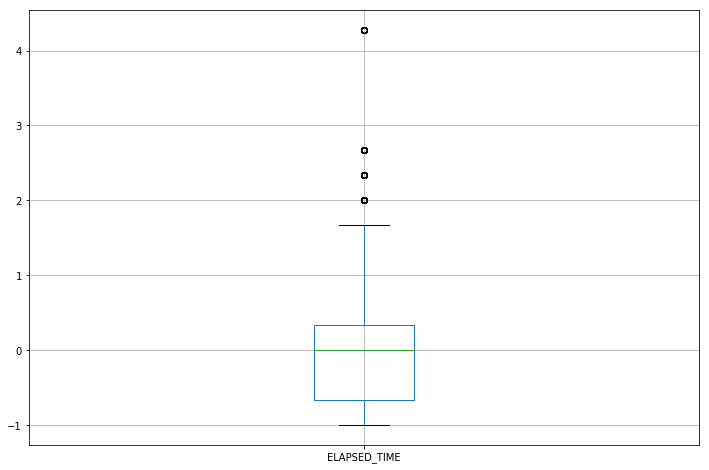

In [183]:
# Distribution of 'Arrival Delay'
ax0 = plt.figure(figsize = (12, 8))
ax0 = y.boxplot(column=['ARR_DELAY']) 

count = 0
for i in range(len(df)):
    if y.ARR_DELAY[i] > 5:
        count += 1
        
print "Outliers:", count

ax1 = plt.figure(figsize = (12, 8))
ax1 = new_train.boxplot(column=['OUT_TAXI', 'IN_TAXI']) 

ax2 = plt.figure(figsize = (12, 8))
ax2 = new_train.boxplot(column=['DEP_TIME', 'NEW_DIST_GROUP']) 

ax3 = plt.figure(figsize = (12, 8))
ax3 = new_train.boxplot(column=['ELAPSED_TIME']) 

### Scatter-Plot

In [ ]:
cols = ['DAY_OF_WEEK', 'CRS_DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'ACTUAL_ELAPSED_TIME', 'DISTANCE_GROUP']
for col in cols:
    print col
    feat = train[col]
    try:
        plt.figure(figsize = (12, 8))
        plt.scatter(feat, y)
        plt.ylabel("Arrival Delay")
        plt.xlabel(col)
        plt.show()
    except ValueError:
        continue

UID


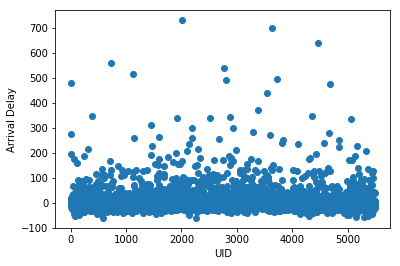

DAY_OF_WEEK


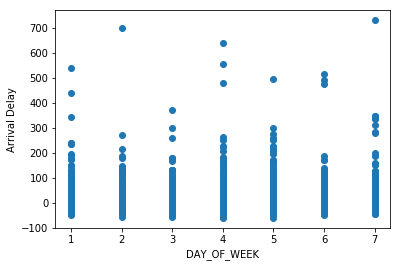

CRS_DEP_TIME


TypeError: float() argument must be a string or a number

TypeError: float() argument must be a string or a number

In [30]:
for col in train:
    print col
    feat = train[col]
    try:
        plt.scatter(feat, y)
        plt.ylabel("Arrival Delay")
        plt.xlabel(col)
        plt.show()
    except ValueError:
        continue

# Mutual Information

In [15]:
### Plotting function for Information Gain of each feature

def plot_info(res, title):
    
    feat = res.keys()
    imp = res.values()
    # Plotting Feature_Names on X-Axis and Feature_importances on Y-Axis
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(feat)), imp)
    plt.xticks(range(len(feat)), feat, rotation=40)
    plt.xlabel('Feature Name')
    plt.ylabel('Feature Importance')
    plt.title(title)
    plt.show()

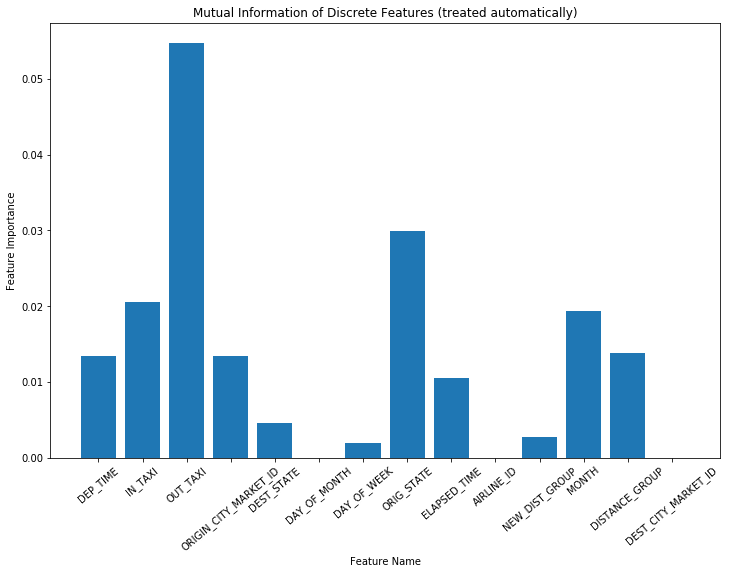

In [16]:
from sklearn.feature_selection import mutual_info_regression

discrete_feat = ['DAY_OF_WEEK', 'DISTANCE_GROUP', 'ORIGIN_CITY_MARKET_ID', 'DEST_CITY_MARKET_ID', 'ORIG_STATE',
                'DAY_OF_MONTH', 'MONTH', 'DEST_STATE', 'DEP_TIME', 'OUT_TAXI', 'IN_TAXI', 'ELAPSED_TIME', 
                 'AIRLINE_ID', 'NEW_DIST_GROUP']
dis_mutual_info = mutual_info_regression(scaled_train[discrete_feat], y, copy = True)

dis_res = dict(zip(discrete_feat, dis_mutual_info))
plot_info(dis_res, "Mutual Information of Discrete Features (treated automatically)")

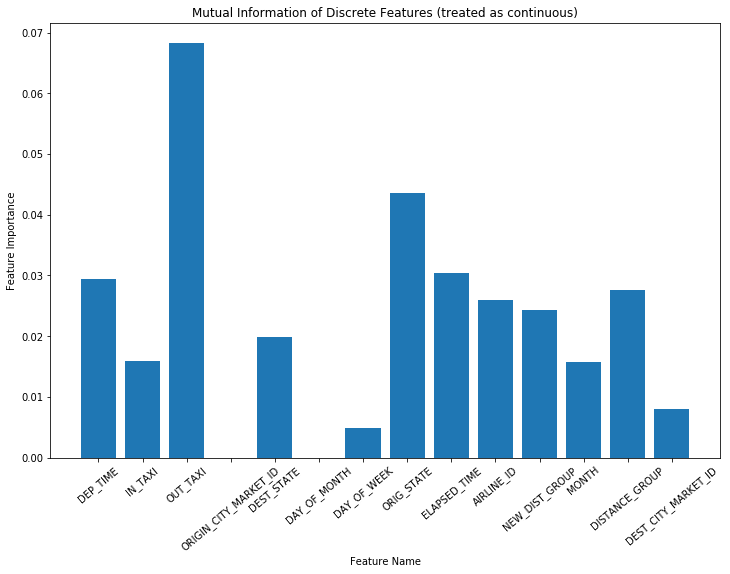

In [17]:
dis_mutual_info = mutual_info_regression(scaled_train[discrete_feat], y, discrete_features = False, copy = True)

dis_res = dict(zip(discrete_feat, dis_mutual_info))
plot_info(dis_res, "Mutual Information of Discrete Features (treated as continuous)")

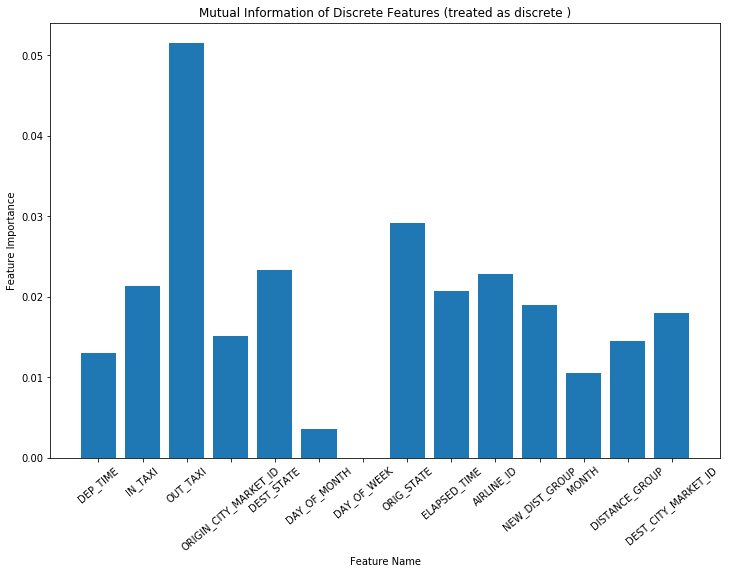

In [18]:
dis_mutual_info = mutual_info_regression(scaled_train[discrete_feat], y,   discrete_features = True, copy = True)

dis_res = dict(zip(discrete_feat, dis_mutual_info))
plot_info(dis_res, "Mutual Information of Discrete Features (treated as discrete )")

In [ ]:
### NOT IN USE

cont_train = new_train.drop(discrete_feat, axis = 1)
cont_mutual_info = mutual_info_regression(cont_train, y,  discrete_features = False, copy = True)

cont_res = dict(zip(cont_train.columns.values, cont_mutual_info))
plot_info(cont_res, "Mutual Information of continuous Features (treated as continuous)")

In [19]:
from sklearn.feature_selection import SelectKBest

kbest = SelectKBest(mutual_info_regression, k=5)
kbest.fit(scaled_train, y)
kbest.get_support(indices=True)

array([ 2,  7, 10, 11, 12])

In [21]:
i = 0
for col in scaled_train:
    print i, col
    i += 1

0 DAY_OF_WEEK
1 DISTANCE_GROUP
2 AIRLINE_ID
3 ORIGIN_CITY_MARKET_ID
4 DEST_CITY_MARKET_ID
5 DAY_OF_MONTH
6 MONTH
7 ORIG_STATE
8 DEST_STATE
9 DEP_TIME
10 OUT_TAXI
11 IN_TAXI
12 ELAPSED_TIME
13 NEW_DIST_GROUP


# Predictive Modelling

### Removing features with low Information Gain

In [43]:
bad_feat = ['DAY_OF_MONTH', 'DEST_CITY_MARKET_ID']
trimmed_train = scaled_train.drop(bad_feat, axis=1)
trimmed_train.head()

,DAY_OF_WEEK,DISTANCE_GROUP,AIRLINE_ID,ORIGIN_CITY_MARKET_ID,MONTH,ORIG_STATE,DEST_STATE,DEP_TIME,OUT_TAXI,IN_TAXI,ELAPSED_TIME,NEW_DIST_GROUP
0,-0.50,2.666667,0.243191,-0.491758,-1.0,1.153846,-0.307692,-1.0,0.0,0.0,2.666667,3.000000
1,0.50,0.666667,0.000000,1.162637,-1.0,-0.500000,0.961538,0.0,0.0,0.0,0.666667,0.714286
2,0.50,2.666667,0.243191,-0.634615,-1.0,-0.653846,-0.538462,-1.0,40.0,0.0,2.333333,2.714286
3,-0.75,0.333333,0.334630,0.551099,-1.0,-0.500000,-0.461538,0.0,0.0,0.0,0.000000,0.428571
4,-0.75,0.000000,-0.801556,-0.580769,-1.0,-0.346154,1.038462,-1.0,20.0,0.0,-0.333333,-0.142857


## 1. Predicting from the mean

In [63]:
#imp_feat = ['AIRLINE_ID', 'ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'IN_TAXI', 'ELAPSED_TIME']
#x = np.copy(trimmed_train[imp_feat])

# 20% split to test set as it will be used in the very end
x_train, x_test, y_train, y_test = np.array(train_test_split(new_train, y, train_size = 0.7))

y_train = np.array(y_train)
mean = y_train.mean()
#inv_scaled_mean = scaler_y.inverse_transform(mean)
preds = []

for i in range(len(y_test)):
    
    preds.append(mean)
    
#print preds
print "Mean Squared Error:", mse(y_test, preds)

Mean Squared Error: 2129.15593423


# 2. Linear Regression

In [65]:
from sklearn.linear_model import LinearRegression

x_train, x_test, y_train, y_test = np.array(train_test_split(new_train, y, train_size = 0.7))

LR_model = LinearRegression()
LR_model.fit(x_train, y_train)
preds = LR_model.predict(x_test)

MSE = mse(y_test, preds)
print MSE

2279.77914848


### K-Fold Cross-Validation

In [251]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def Linear_Regression(train, y, deg, folds):
    
    MSE_stats = []

    for j in range(folds):

        MSE_list = []

        kf = KFold(len(train), n_folds = folds, shuffle=True) 

        for tr, te in kf:
            x_train = [train[ii] for ii in tr]
            y_train = [y[ii] for ii in tr]
            x_test = [train[ii] for ii in te]
            y_test = [y[ii] for ii in te]

        LR_model = Pipeline([('poly', PolynomialFeatures(degree = deg)),('linear', LinearRegression())])

        LR_model.fit(x_train, y_train)
        preds = LR_model.predict(x_test)
        #print preds
        
        inv_scaled_pred = scaler_y.inverse_transform(preds)
        inv_scaled_y = scaler_y.inverse_transform(y_test)
        #print preds, inv_scaled_pred

        MSE = mse(inv_scaled_y, inv_scaled_pred)
        MSE_list.append(MSE)

        MSE_stats.append(MSE_list)
    
    return MSE_stats

#imp_feat = ['AIRLINE_ID', 'ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'IN_TAXI', 'ELAPSED_TIME',
#            'ORIGIN_CITY_MARKET_ID', 'DISTANCE_GROUP']
imp_feat = ['ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'ELAPSED_TIME']

train_set = np.copy(trimmed_train[imp_feat])
MSE_stats = Linear_Regression(train_set, y.values, 1, 10)
print MSE_stats
np.mean(MSE_stats)

[[1974.0448932284348], [1034.4327427964172], [2067.1196971651229], [2089.065407004151], [2676.7604944125164], [2129.4889305851475], [1682.0493905344817], [1168.3468966454334], [1618.3248775146167], [1454.8672040730778]]


1789.4500533959399

### Degree - 2

In [252]:
MSE_stats = Linear_Regression(train_set, y.values, 2, 10)
print MSE_stats
np.mean(MSE_stats)

[[1243.4391455411537], [1443.0348238173394], [2342.5582685687509], [2190.9863691464516], [2265.8563207024058], [1993.3359409083084], [1037.1767544796776], [2000.2431764842552], [1167.4941111897813], [919.40157698724602]]


1660.352648782537

### Degree - 3

In [255]:
MSE_stats = Linear_Regression(train_set, y.values, 3, 10)
print MSE_stats
np.mean(MSE_stats)

[[1287.3062829449379], [1942.81884369197], [1470.3424789489575], [2522.8061097806772], [3762.2617254363608], [1378.363121082928], [1629.1252418116153], [1724.526694010965], [1343.1156074334299], [2532.3312482267092]]


1959.2997353368551

## 3. Decision Tree

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

x_train, x_test, y_train, y_test = np.array(train_test_split(scaled_train, y, train_size = 0.7))


leaves = [1, 2, 3, 5, 7, 10, 15, 30, 50, 70, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 1000, 2000, 5000, 8000, 10000]

train_set = np.copy(scaled_train)

for i in leaves:
    
    DT_model = DecisionTreeRegressor(min_samples_leaf=i)
    DT_model.fit(x_train, y_train)
    preds = DT_model.predict(x_test)
    cv_score = cross_val_score(DT_model, train_set, y, cv = 5, scoring='neg_mean_squared_error')
    print "Leaves: ", i, "Squared error: ", -cv_score.mean()

Leaves:  1 Squared error:  5147.11274477
Leaves:  2 Squared error:  3758.20325714
Leaves:  3 Squared error:  3140.58527971
Leaves:  5 Squared error:  2791.33806718
Leaves:  7 Squared error:  2640.42459891
Leaves:  10 Squared error:  2352.85896453
Leaves:  15 Squared error:  2223.67120273
Leaves:  30 Squared error:  2109.50204621
Leaves:  50 Squared error:  2057.61442667
Leaves:  70 Squared error:  2037.58778497
Leaves:  100 Squared error:  2056.86420803
Leaves:  200 Squared error:  2029.86794322
Leaves:  500 Squared error:  2025.02263071
Leaves:  1000 Squared error:  2064.21255694
Leaves:  2000 Squared error:  2062.58142851
Leaves:  3000 Squared error:  2062.58142851
Leaves:  4000 Squared error:  2062.58142851
Leaves:  5000 Squared error:  2062.58142851
Leaves:  1000 Squared error:  2064.21255694
Leaves:  2000 Squared error:  2062.58142851
Leaves:  5000 Squared error:  2062.58142851
Leaves:  8000 Squared error:  2062.58142851
Leaves:  10000 Squared error:  2062.58142851


### Information Gain from Decision Tree

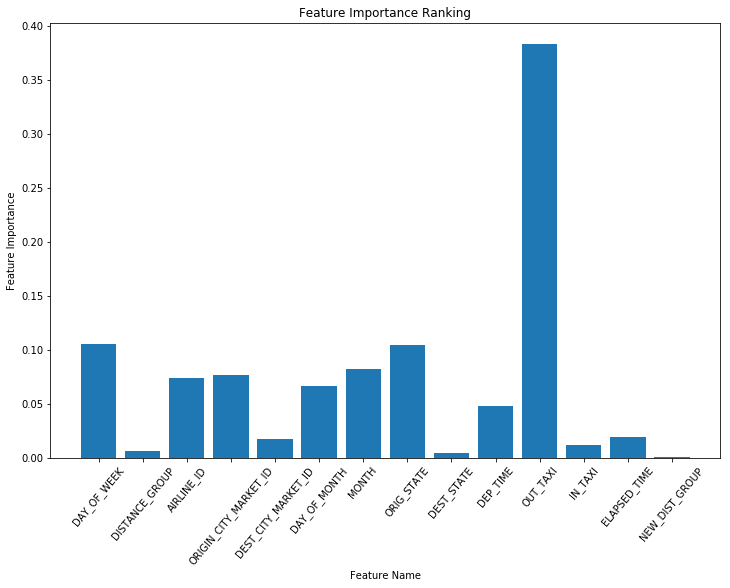

In [72]:
DT_model = DecisionTreeRegressor(min_samples_leaf=50)
DT_model.fit(x_train, y_train)

fi = DT_model.feature_importances_
#x_train=train_df.drop('churndep', axis=1)
feat_names = np.array( scaled_train.columns.values)

# Plotting Feature_Names on X-Axis and Feature_importances on Y-Axis
plt.figure(figsize=(12, 8))
plt.bar(range(len(feat_names)), fi)
plt.xticks(range(len(feat_names)), feat_names, rotation=50)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Ranking')
plt.show()

# 4. Random Forest Regressor

In [267]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor

def kfold_random_forest(train, y, trees, folds, msl):
    
    MSE_stats = pd.DataFrame()
    R2_stats = pd.DataFrame()
    
    for j in range(folds):

        MSE_list = []

        kf = KFold(len(train), n_folds = folds, shuffle=True) 

        for train, test in kf:
            x_train = [train_set[ii] for ii in train]
            y_train = [y[ii] for ii in train]
            x_test = [train_set[ii] for ii in test]
            y_test = [y[ii] for ii in test]

        for i in trees:
            RF_model = RandomForestRegressor(n_estimators=i, min_samples_leaf=msl)
            RF_model.fit(x_train, y_train)
            preds = RF_model.predict(x_test)
                    
            # Scaling back the predictions before caclulating the Mean-Squared Error
            inv_scaled_pred = scaler_y.inverse_transform(preds.reshape(-1, 1))
            inv_scaled_y = scaler_y.inverse_transform(y_test)
            
            MSE = mse(inv_scaled_y, inv_scaled_pred)
            MSE_list.append(MSE)

        MSE_stats[j] = MSE_list
    
    return MSE_stats

In [271]:
#train_set = np.copy(trimmed_train)

trees = [5, 10, 30, 50, 80, 100, 200, 500, 1000]
msl = [20, 50, 100, 200, 300, 400, 500, 800]

for ms in msl:   
    print "\nMin_samples_leaf: ", ms
    MSE_stats = kfold_random_forest(train_set, y.values, trees, 5, ms)

    kfold_mean_MSE = {}

    for i in range(len(trees)):
        print "Trees:", trees[i]

        kfold_mean_MSE[i] = MSE_stats.loc[i].mean()
        print "\tMSE:", kfold_mean_MSE[i]


Min_samples_leaf:  20


/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Trees: 5
	MSE: 1598.99483844
Trees: 10
	MSE: 1592.47190608
Trees: 30
	MSE: 1580.52190317
Trees: 50
	MSE: 1580.26380754
Trees: 80
	MSE: 1578.09788237
Trees: 100
	MSE: 1581.37847748
Trees: 200
	MSE: 1576.22028534
Trees: 500
	MSE: 1577.4958232
Trees: 1000
	MSE: 1576.5804419

Min_samples_leaf:  50
Trees: 5
	MSE: 2405.69709704
Trees: 10
	MSE: 2397.98894681
Trees: 30
	MSE: 2389.40364273
Trees: 50
	MSE: 2390.24084177
Trees: 80
	MSE: 2387.9472876
Trees: 100
	MSE: 2388.33898696
Trees: 200
	MSE: 2389.06337244
Trees: 500
	MSE: 2389.25478438
Trees: 1000
	MSE: 2388.63513426

Min_samples_leaf:  100
Trees: 5
	MSE: 1746.83334248
Trees: 10
	MSE: 1750.86691751
Trees: 30
	MSE: 1745.32264368
Trees: 50
	MSE: 1745.17494814
Trees: 80
	MSE: 1745.32915202
Trees: 100
	MSE: 1745.56567334
Trees: 200
	MSE: 1745.36460763
Trees: 500
	MSE: 1745.461019
Trees: 1000
	MSE: 1745.05376011

Min_samples_leaf:  200
Trees: 5
	MSE: 1816.35571062
Trees: 10
	MSE: 1818.13206205
Trees: 30
	MSE: 1817.68659066
Trees: 50
	MSE: 1816.91

# Support Vector Machines

In [307]:
from sklearn.svm import SVR
from sklearn.cross_validation import KFold

def kfold_SVM(train_set, y, kernels, folds):

    MSE_stats = pd.DataFrame()
    
    for j in range(folds):

        MSE_list = []

        kf = KFold(len(train_set), n_folds = folds, shuffle=True) 

        for train, test in kf:
            
            x_train = [train_set[ii] for ii in train]
            y_train = [y[ii] for ii in train]
            x_test = [train_set[ii] for ii in test]
            y_test = [y[ii] for ii in test]
            
        for i in kernels:
            SVM_model = SVR(kernel = i, epsilon = 0.1, degree=2)
            SVM_model.fit(x_train, y_train)
            preds = SVM_model.predict(x_test)

            inv_scaled_pred = scaler_y.inverse_transform(preds.reshape(-1, 1))
            inv_scaled_y = scaler_y.inverse_transform(y_test)

            MSE = mse(inv_scaled_y, inv_scaled_pred)
            MSE_list.append(MSE)

        MSE_stats[j] = MSE_list
    
    return MSE_stats

In [ ]:
#imp_feat = ['AIRLINE_ID', 'ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'IN_TAXI', 'ELAPSED_TIME',
#           'ORIGIN_CITY_MARKET_ID', 'DISTANCE_GROUP']
imp_feat = ['ORIG_STATE', 'DEP_TIME', 'OUT_TAXI', 'ELAPSED_TIME']

train_set = np.copy(trimmed_train[imp_feat])

#kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
kernels = ['linear', 'rbf', 'sigmoid']

folds = 8
MSE_stats = kfold_SVM(train_set, np.copy(y), kernels, folds)

kfold_mean_MSE = {}

for i in range(len(kernels)):
    print "Kernel:", kernels[i]
    
    kfold_mean_MSE[i] = MSE_stats.loc[i].mean()
    print "\tMSE:", kfold_mean_MSE[i]

# Random Forests

In [245]:
from sklearn.ensemble import RandomForestRegressor

trees = [5, 10, 20, 30, 50, 70, 80, 100, 200, 500, 700, 1000, 2000]
for i in trees:
    RF_model = RandomForestRegressor(n_estimators=i)
    RF_model.fit(x_train, y_train)
    
    preds_train = RF_model.predict(x_train)
    print i, "Training MSE:", mse(y_train, preds_train)    
    
    preds_test = RF_model.predict(x_test)
    print i, "Testing MSE:", mse(y_test, preds_test)
    R_squared = RF_model.score(x_test, y_test)
    #R2.append([R_squared, i])
    print i, "R^2 value:", R_squared

5 Training MSE: 587.149898167
5 Testing MSE: 2450.64629579
5 R^2 value: -0.210993789801
10 Training MSE: 448.519071865
10 Testing MSE: 2311.19717775
10 R^2 value: -0.142084614195
20 Training MSE: 362.384228251
20 Testing MSE: 2134.08387551
20 R^2 value: -0.0545635755728
30 Training MSE: 338.353672777
30 Testing MSE: 2038.95371702
30 R^2 value: -0.00755473902654
50 Training MSE: 324.591044748
50 Testing MSE: 2063.62005617
50 R^2 value: -0.0197436801978
70 Training MSE: 296.624484214
70 Testing MSE: 2082.69546908
70 R^2 value: -0.0291698493724
80 Training MSE: 299.93654868
80 Testing MSE: 2094.91752968
80 R^2 value: -0.0352094151426
100 Training MSE: 317.129987315
100 Testing MSE: 2072.98000142
100 R^2 value: -0.0243689235842
200 Training MSE: 306.531465697
200 Testing MSE: 2032.651494
200 R^2 value: -0.00444047771582
500 Training MSE: 287.922813978
500 Testing MSE: 2040.90766979
500 R^2 value: -0.00852029030886
700 Training MSE: 286.124219336
700 Testing MSE: 2028.46338733
700 R^2 value